<a href="https://colab.research.google.com/github/ynyonato/HandsOn/blob/main/ia_me_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
# Import des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

In [63]:
# Télécharger stopwords et autres ressources NLTK si besoin
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [67]:
# Chargement des données (ici on suppose que le fichier csv est uploadé dans Colab)
df = pd.read_csv('ia-me/suivi_activites.csv', sep=';', encoding='latin-1', quotechar='"')
print(df.columns)
print(df.head())

Index(['ID_Activite', 'Date', 'Type_Activite', 'Nombre_Participants',
       'Localisation', 'Feedback', 'Resultat_Attendu'],
      dtype='object')
   ID_Activite        Date             Type_Activite  Nombre_Participants  \
0            1  05/01/2025  Distribution de matériel                   25   
1            2  10/01/2025         Atelier formation                   15   
2            3  15/01/2025          Suivi individuel                   10   
3            4  20/01/2025  Distribution de matériel                   30   
4            5  25/01/2025         Atelier formation                   20   

  Localisation                                      Feedback Resultat_Attendu  
0      Ville A    Les bénéficiaires ont apprécié la rapidité         Réussite  
1      Ville B                Manque de matériel pédagogique           Risque  
2      Ville A  Très bonne interaction avec les participants         Réussite  
3      Ville C  Certains participants sont arrivés en retard         

In [68]:
# Nettoyage basique du texte (feedback)
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zàâçéèêëîïôûùüÿñæœ\s]", '', text)  # enlever ponctuations sauf lettres accentuées
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['Feedback_clean'] = df['Feedback'].fillna('').apply(clean_text)
# print(df['Feedback_clean'].head())

In [69]:
# Suppression des stopwords
stop_words = set(stopwords.words('french'))
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

df['Feedback_clean'] = df['Feedback_clean'].apply(remove_stopwords)
# print(df['Feedback_clean'].head())

In [70]:
# Check if there are any non-empty strings after cleaning and stopword removal
if df['Feedback_clean'].str.strip().eq('').all():
    print("Erreur: Après nettoyage et suppression des mots vides, la colonne 'Feedback_clean' est vide. Impossible de créer un vocabulaire TF-IDF.")
    # Option 1: Print some raw feedback to understand why it's empty
    print("\nExemples de feedback originaux :")
    print(df['Feedback'].head())
    # Option 2: You might need to revisit your cleaning steps or data source
else:
    vectorizer = TfidfVectorizer(max_features=20)
    X = vectorizer.fit_transform(df['Feedback_clean'])
    tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

    # Somme des TF-IDF par mot pour voir les plus importants
    tfidf_sum = tfidf_df.sum().sort_values(ascending=False)
    print("Top mots-clés TF-IDF :")
    print(tfidf_sum)

Top mots-clés TF-IDF :
participants     4.379917
manque           3.865247
bénéficiaires    3.654961
suivi            3.381728
bonne            3.303900
très             3.303900
besoin           3.000000
problèmes        2.358045
matériel         2.330520
positif          2.000000
distribution     2.000000
globale          2.000000
organisation     2.000000
efficace         1.755663
motivés          1.577801
certains         1.544563
mineurs          1.468235
insuffisant      1.284457
support          1.284457
pédagogique      1.206471
dtype: float64


In [71]:
X = vectorizer.fit_transform(df['Feedback_clean'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

In [73]:
# Somme des TF-IDF par mot pour voir les plus importants
tfidf_sum = tfidf_df.sum().sort_values(ascending=False)
print("Top mots-clés TF-IDF :")
print(tfidf_sum)

Top mots-clés TF-IDF :
participants     4.379917
manque           3.865247
bénéficiaires    3.654961
suivi            3.381728
bonne            3.303900
très             3.303900
besoin           3.000000
problèmes        2.358045
matériel         2.330520
positif          2.000000
distribution     2.000000
globale          2.000000
organisation     2.000000
efficace         1.755663
motivés          1.577801
certains         1.544563
mineurs          1.468235
insuffisant      1.284457
support          1.284457
pédagogique      1.206471
dtype: float64


In [74]:
# Analyse de sentiment avec TextBlob (en français)
# On utilise TextBlob directement ici, qui marche mieux en anglais, mais ça donnera un aperçu
# Pour un vrai traitement en français, on pourrait utiliser d’autres libs (ex: HuggingFace)
def sentiment_polarity(text):
    return TextBlob(text).sentiment.polarity

df['Sentiment'] = df['Feedback_clean'].apply(sentiment_polarity)

In [75]:
# Catégorisation simple du sentiment
def categorize_sentiment(score):
    if score > 0.1:
        return 'Positif'
    elif score < -0.1:
        return 'Négatif'
    else:
        return 'Neutre'

df['Sentiment_cat'] = df['Sentiment'].apply(categorize_sentiment)

In [76]:
# Affichage des counts sentiment
print("\nRépartition des sentiments :")
print(df['Sentiment_cat'].value_counts())


Répartition des sentiments :
Sentiment_cat
Neutre     49
Négatif     1
Name: count, dtype: int64


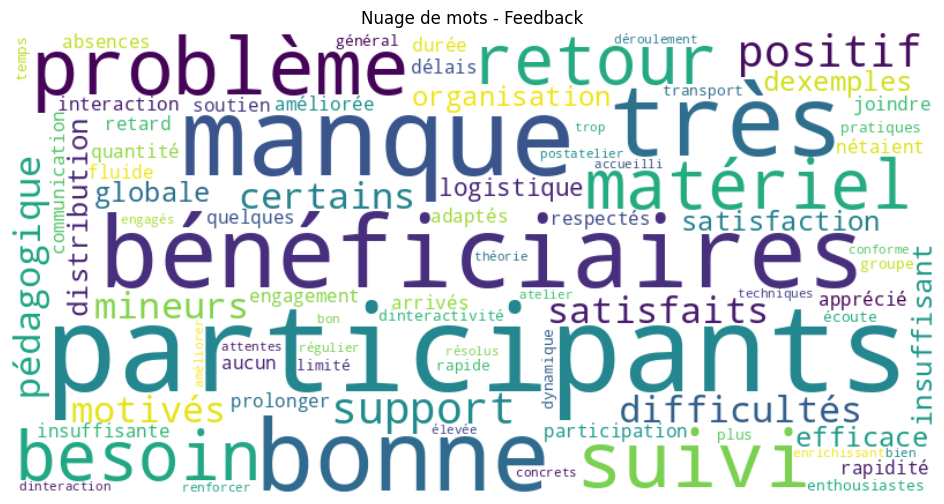

In [59]:
# Nuage de mots pour feedback global
all_text = ' '.join(df['Feedback_clean'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots - Feedback")
plt.show()

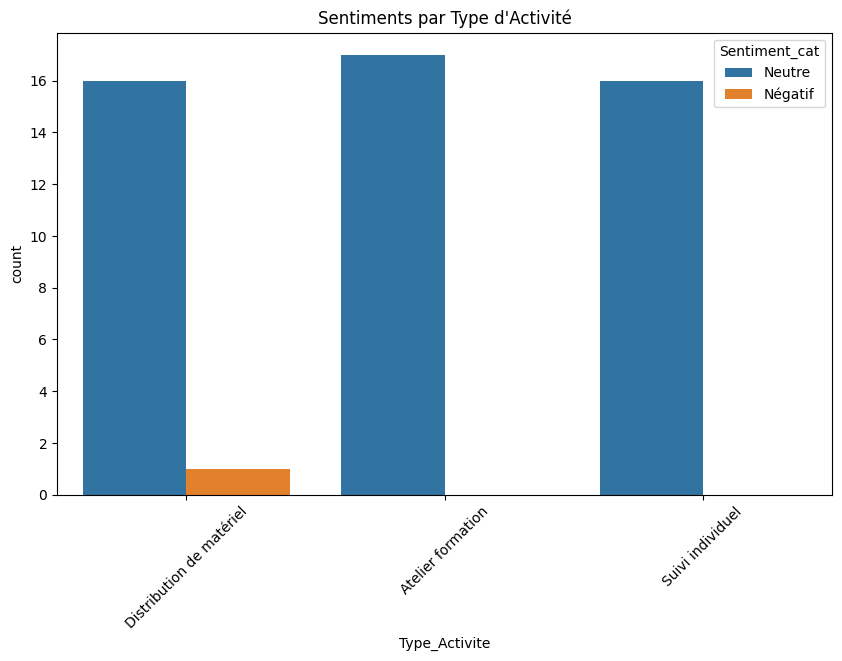

In [60]:
# Graphique des sentiments par type d'activité
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Type_Activite', hue='Sentiment_cat')
plt.title("Sentiments par Type d'Activité")
plt.xticks(rotation=45)
plt.show()

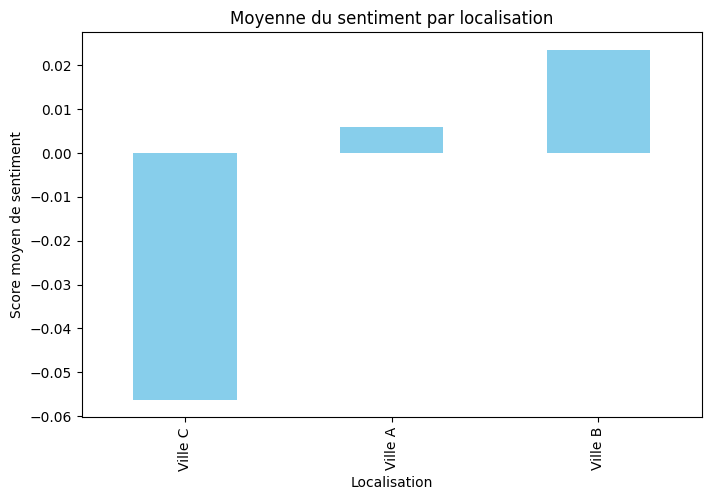

In [61]:
# Moyenne de sentiment par localisation
sentiment_localisation = df.groupby('Localisation')['Sentiment'].mean().sort_values()

plt.figure(figsize=(8,5))
sentiment_localisation.plot(kind='bar', color='skyblue')
plt.title("Moyenne du sentiment par localisation")
plt.ylabel("Score moyen de sentiment")
plt.show()

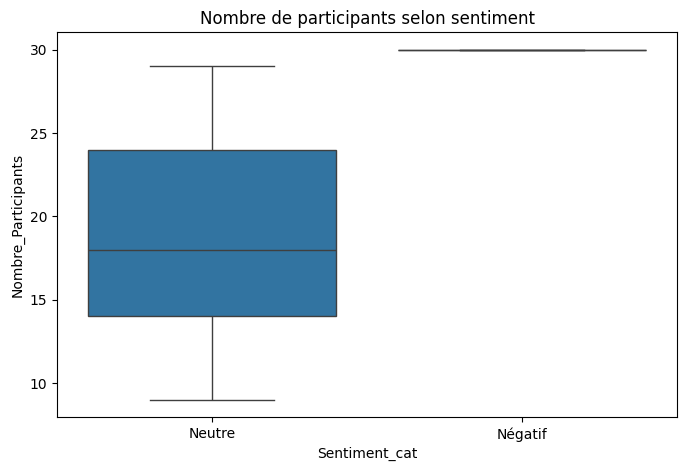

In [48]:
# Croisement nombre participants vs sentiment (boxplot)
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='Sentiment_cat', y='Nombre_Participants')
plt.title("Nombre de participants selon sentiment")
plt.show()